# Stationary state

In [1]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
import solve_kolmogorov
import Hypergraphs

from scipy.integrate import solve_ivp

In [2]:
"""Complete case test."""
# setup
nsims = 10 # number of simulation runs
time_max = 20  # maximum time duration TODO: can increase to 100 if necessary

N = 100
g = Hypergraphs.CompleteHypergraph(N)

I0 = 10 # number of initial infected
initial_infections = list(range(I0)) # which nodes are infected at t=0 doesn't matter

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = {g.__class__.__name__}, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}, time_max = {time_max}\n")

Setup: 

	H = CompleteHypergraph, N = 100, I0 = 10

	beta1 = 0.02, beta2 = 0.0004, mu = 1, time_max = 20



In [3]:
k_star = np.zeros((10, 10))
# k_star

In [4]:
eps = 1e-1 # shift for esp to not start with 0 !
beta1_vec = (np.array(list(range(10))) + eps) / N
beta2_vec = (np.array(list(range(10))) + eps) / (N**2)
beta1_vec


array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091])

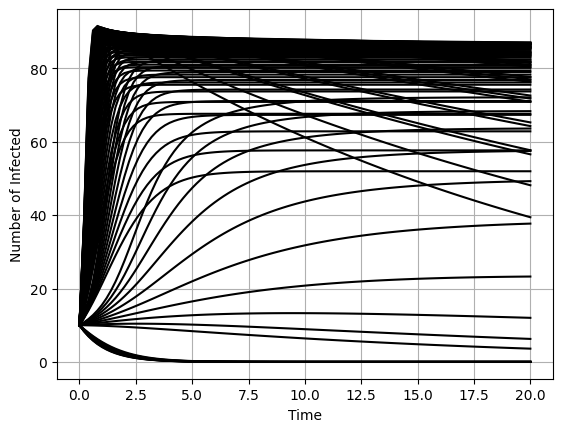

In [ ]:
all_states = solve_kolmogorov.list_all_states(g)
M = len(all_states)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

t_span = (0.0, time_max)
npoints = 101

plt.figure()
for i, beta1 in enumerate(beta1_vec):
    for j, beta2 in enumerate(beta2_vec):

        # times t_i to evaluate in, get saved in sol.t
        t_eval = np.linspace(t_span[0], t_span[1], npoints)
        ode_system_complete = solve_kolmogorov.list_all_ODEs_complete(
            g, beta1, beta2, mu)

        def f_ode(t, p):
            return ode_system_complete(t, p)

        sol = solve_ivp(f_ode, 
                        t_span, 
                        p0, 
                        t_eval=t_eval,
                        method="RK45"
        )
        expected_values = solve_kolmogorov.calculate_expected_values(sol)

        k_star[i, j] = expected_values[-1]

        plt.plot(sol.t, expected_values, color="k")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
# plt.legend() # no legend
plt.grid(True)
plt.show()

In [ ]:
# TODO: if derivative is negative then stop and put 0
# postprocess it:
# eps = 1e-6
# Take finite diference: E[X(t_final)] - E[X(t_final - delta_t)] < eps

In [28]:
k_star

array([[4.54007928e-04, 4.74334708e-04, 4.97247601e-04, 5.23323417e-04,
        5.53362110e-04, 5.88502065e-04, 6.30460447e-04, 6.82135619e-04,
        7.56099798e-04, 1.19429400e-03],
       [3.34151810e+00, 4.56423805e+00, 6.72807023e+00, 1.08715684e+01,
        1.85212181e+01, 2.96990614e+01, 4.14291404e+01, 5.12068694e+01,
        5.87736988e+01, 6.46285110e+01],
       [4.87904079e+01, 5.48877062e+01, 6.05515749e+01, 6.54850808e+01,
        6.96255398e+01, 7.30473706e+01, 7.58702540e+01, 7.82117080e+01,
        8.01705362e+01, 8.18241649e+01],
       [6.61486364e+01, 6.95975758e+01, 7.26319507e+01, 7.52619178e+01,
        7.75253371e+01, 7.94703756e+01, 8.11448883e+01, 8.25908373e+01,
        8.38412087e+01, 8.49175641e+01],
       [7.46588273e+01, 7.68348244e+01, 7.87514827e+01, 8.04338760e+01,
        8.19093213e+01, 8.32030661e+01, 8.43348649e+01, 8.53156718e+01,
        8.61440635e+01, 8.68024765e+01],
       [7.97450454e+01, 8.12357845e+01, 8.25602002e+01, 8.37342456e+01,
   